In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision import *
from fastai import *
import os
from collections import defaultdict

### Set up paths

In [2]:
train_pd = pd.read_csv('/root/.fastai/data/severstal/train.csv')

In [3]:
train_pd.head(5)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [4]:
path = Path('/root/.fastai/data/severstal')

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/severstal/severstal-steel-defect-detection.zip'),
 PosixPath('/root/.fastai/data/severstal/test_images'),
 PosixPath('/root/.fastai/data/severstal/train_images'),
 PosixPath('/root/.fastai/data/severstal/train.csv'),
 PosixPath('/root/.fastai/data/severstal/submission.csv'),
 PosixPath('/root/.fastai/data/severstal/train_images.zip'),
 PosixPath('/root/.fastai/data/severstal/sample_submission.csv'),
 PosixPath('/root/.fastai/data/severstal/test_images.zip')]

In [6]:
train_images = get_image_files(path/'train_images')
train_images[:3]

[PosixPath('/root/.fastai/data/severstal/train_images/18ba753ff.jpg'),
 PosixPath('/root/.fastai/data/severstal/train_images/0519989b3.jpg'),
 PosixPath('/root/.fastai/data/severstal/train_images/7933cbe21.jpg')]

### Check maximum size of images

In [7]:
def check_img_max_size(folder):
    max_height = 0
    max_width = 0
    for train_image in train_images:
        img = open_image(train_image)
        if max_height < img.shape[1]:
            max_height = img.shape[1]
        if max_width < img.shape[2]:
            max_width = img.shape[2]
    return max_height, max_width

def show_image(images, index):
    img_f = images[index]
    print(type(img_f))
    img = open_image(img_f)
    print(img)
    img.show(figsize=(5,5))

<class 'pathlib.PosixPath'>
Image (3, 256, 1600)


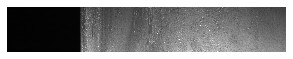

In [8]:
show_image(train_images, 0)

In [9]:
mask_path = Path('/kaggle/mask')
if not os.path.exists(mask_path):
    os.makedirs(str(mask_path))

In [10]:
def convert_encoded_to_array(encoded_pixels):
    pos_array = []
    len_array = []
    splits = encoded_pixels.split()
    pos_array = [int(n) - 1 for i, n in enumerate(splits) if i % 2 == 0]
    len_array = [int(n) for i, n in enumerate(splits) if i % 2 == 1]
    return pos_array, len_array
        
def convert_to_pair(pos_array, rows):
    return [(p % rows, p // rows) for p in pos_array]

def create_positions(single_pos, size):
    return [i for i in range(single_pos, single_pos + size)]

def create_positions_pairs(single_pos, size, row_size):
    return convert_to_pair(create_positions(single_pos, size), row_size)

def convert_to_mask(encoded_pixels, row_size, col_size, category):
    pos_array, len_array = convert_encoded_to_array(encoded_pixels)
    mask = np.zeros([row_size, col_size])
    for(p, l) in zip(pos_array, len_array):
        for row, col in create_positions_pairs(p, l, row_size):
            mask[row][col] = category
    return mask

def save_to_image(masked, image_name):
    im = PIL.Image.fromarray(masked)
    im = im.convert("L")
    image_name = re.sub(r'(.+)\.jpg', r'\1', image_name) + ".png"
    real_path = mask_path/image_name
    im.save(real_path)
#     print(f'Image saved to ${real_path}')
    return real_path

def open_single_image(path):
    img = open_image(path)
    img.show(figsize=(20,20))
    
def get_y_fn(x):
    return mask_path/(x.stem + '.png')

def group_by(train_images, train_pd):
    tran_dict = {image.name:[] for image in train_images}
    pattern = re.compile('(.+)_(\d+)')
    for index, image_path in train_pd.iterrows():
        m = pattern.match(image_path['ImageId_ClassId'])
        file_name = m.group(1)
        category = m.group(2)
        tran_dict[file_name].append((int(category), image_path['EncodedPixels']))
    return tran_dict

def display_image_with_mask(img_name):
    full_image = path/'train_images'/img_name
    print(full_image)
    open_single_image(full_image)
    mask_image = get_y_fn(full_image)
    mask = open_mask(mask_image)
    print(full_image)
    mask.show(figsize=(20, 20), alpha=0.5)

In [11]:
grouped_categories_mask = group_by(train_images, train_pd)

### Fetching images with more than n categories

In [12]:
def add_mask(cat_mask):
    sum = 0
    if pd.notna(cat_mask[0][1]):
        sum += 1
    if pd.notna(cat_mask[1][1]):
        sum += 1
    if pd.notna(cat_mask[2][1]):
        sum += 1
    if pd.notna(cat_mask[3][1]):
        sum += 1
    return sum

multi_cat = [i[0] for i in grouped_categories_mask.items() if add_mask(i[1]) > 2]
multi_cat

['db4867ee8.jpg', 'ef24da2ba.jpg']

### Create mask files and save these to kaggle/mask/

In [13]:
image_height = 256
image_width = 1600
for image_name, cat_list in grouped_categories_mask.items():
    masked = np.zeros([image_height, image_width])
    for cat_mask in cat_list:
        encoded_pixels = cat_mask[1]
        if pd.notna(cat_mask[1]):
            masked += convert_to_mask(encoded_pixels, image_height, image_width, cat_mask[0])
    if np.amax(masked) > 4:
        print(f'Check {image_name} for max category {np.amax(masked)}')
    save_to_image(masked, image_name)

In [14]:
# check_img_max_size(mask_path)

In [15]:
def test_decoding_functions():
    pos_array, len_array = convert_encoded_to_array(train_pd[0:1]['EncodedPixels'][0])
    print(convert_to_pair([0, 1, 2, 3, 4, 5], 3))
    print(convert_to_pair(pos_array, 256))
    print(create_positions(3, 4))
    create_positions_pairs(3, 4, 3)
    # masked = convert_to_mask(pd.Series(["1 3 10 5"]), 3, 6, 1)
    # masked
    masked = convert_to_mask(train_pd[:1]['EncodedPixels'][0], 256, 1600, 1)
    df_masked = pd.DataFrame (masked)
    im = PIL.Image.fromarray(masked)
    im = im.convert("L")
    dummy_img = re.sub(r'(.+)_\d+', r'\1', train_pd[0:1]['ImageId_ClassId'][0])
    real_path = save_to_image(masked, dummy_img)
    open_single_image(real_path)

#### Data checks

/root/.fastai/data/severstal/train_images/d482f0159.jpg
/root/.fastai/data/severstal/train_images/d482f0159.jpg


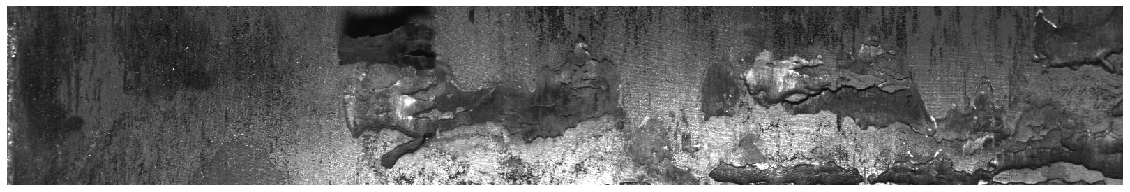

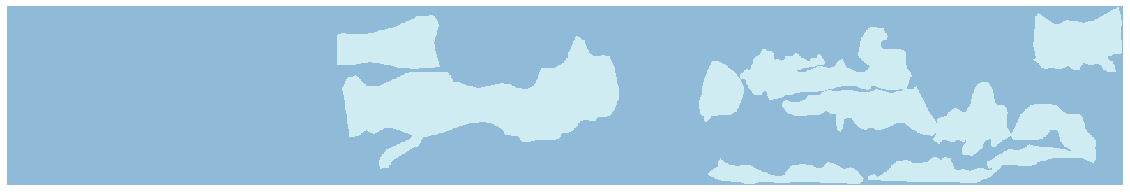

In [16]:
display_image_with_mask('d482f0159.jpg')

/root/.fastai/data/severstal/train_images/db4867ee8.jpg
/root/.fastai/data/severstal/train_images/db4867ee8.jpg


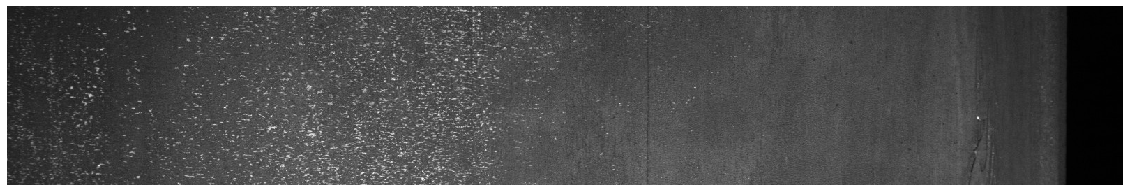

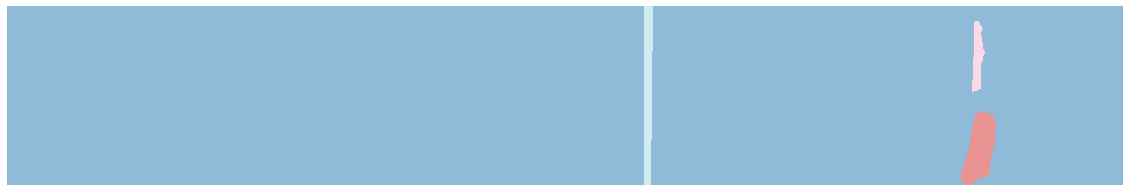

In [17]:
display_image_with_mask('db4867ee8.jpg')

In [18]:
from IPython.display import HTML
import base64

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)


im = PIL.Image.open("/kaggle/mask/db4867ee8.png")
create_download_link(pd.DataFrame(np.array(im)))

### Prepare data bunch

In [19]:
train_images = (path/'train_images').ls()
src_size = np.array(open_image(str(train_images[0])).shape[1:])

In [20]:
codes = array(['0', '1', '2', '3', '4'])
src = (SegmentationItemList.from_folder(path/'train_images')
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [21]:
bs, size = 2, src_size//2

In [22]:
data = (src.transform(get_transforms(flip_vert = True), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

### Create learner and training
Starting with low resolution training

##### Some metrics functions

In [23]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['0']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    argmax = (input.argmax(dim=1))
    comparison = argmax[mask]==target[mask]
    return torch.tensor(0.) if comparison.numel() == 0 else comparison.float().mean()

def acc_camvid_with_zero_check(input, target):
    target = target.squeeze(1)
    argmax = (input.argmax(dim=1))
    batch_size = input.shape[0]
    total = torch.empty([batch_size])
    for b in range(batch_size):
        if(torch.sum(argmax[b]).item() == 0.0 and torch.sum(target[b]).item() == 0.0):
            total[b] = 1
        else:
            mask = target[b] != void_code
            comparison = argmax[b][mask]==target[b][mask]
            total[b] = torch.tensor(0.) if comparison.numel() == 0 else comparison.float().mean()
    return total.mean()


def calc_dice_coefficients(a, target, cats):
    def calc_dice_coefficient(seg, gt, cat: int):
        mask_seg = seg == cat
        mask_gt = gt == cat
        sum_seg = torch.sum(mask_seg.long()).float()
        sum_gt = torch.sum(mask_gt.long()).float()
        if sum_seg + sum_gt == 0:
            return torch.tensor(1.0)
        return (torch.sum((seg[gt == cat] / cat).long()) * 2.0) / (sum_seg + sum_gt)

    total_avg = torch.empty([len(cats)])
    for i, c in enumerate(cats):
        total_avg[i] = calc_dice_coefficient(a, target, c)
    return total_avg.mean()


def dice_coefficient(input, target):
    target = target.squeeze(1)
    argmax = (input.argmax(dim=1))
    batch_size = input.shape[0]
    cats = [1, 2, 3, 4]
    total = torch.empty([batch_size])
    for b in range(batch_size):
        total[b] = calc_dice_coefficients(argmax[b], target[b], cats)
    return total.mean()


def accuracy_simple(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()


def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

In [24]:
test_input = torch.ones([8, 5, 360, 480]).long()
target_input = torch.ones([8, 1, 360, 480]).long() + 3
accuracy_simple(test_input, target_input), dice_coefficient(test_input, target_input), acc_camvid_with_zero_check(test_input, target_input)

(tensor(1.), tensor(1.), tensor(1.))

In [25]:
test_input = torch.ones([8, 1, 360, 480]).long()
target_input = torch.ones([8, 1, 360, 480]).long()
accuracy_simple(test_input, target_input), dice_coefficient(test_input, target_input), acc_camvid_with_zero_check(test_input, target_input)

(tensor(0.), tensor(0.7500), tensor(0.))

In [26]:
test_input = torch.zeros([8, 1, 360, 480]).long()
target_input = torch.zeros([8, 1, 360, 480]).long()
accuracy_simple(test_input, target_input), dice_coefficient(test_input, target_input), acc_camvid_with_zero_check(test_input, target_input)

(tensor(1.), tensor(1.), tensor(1.))

In [154]:
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        return self.dice_loss(target, input)

    def dice_loss(self, true, logits, eps=1e-7):
        """Computes the Sørensen–Dice loss.
        Note that PyTorch optimizers minimize a loss. In this
        case, we would like to maximize the dice loss so we
        return the negated dice loss.
        Args:
            true: a tensor of shape [B, 1, H, W].
            logits: a tensor of shape [B, C, H, W]. Corresponds to
                the raw output or logits of the model.
            eps: added to the denominator for numerical stability.
        Returns:
            dice_loss: the Sørensen–Dice loss.
        """
        num_classes = logits.shape[1]
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
        true_1_hot = true_1_hot.type(logits.type())
#         true_1_hot = true_1_hot[:,1:]
#         probas = probas[:,1:]
        dims = (0,) + tuple(range(2, true.ndimension()))
        intersection = torch.sum(probas * true_1_hot, dims)
        cardinality = torch.sum(probas + true_1_hot, dims)
        print(cardinality)
        mask_is_zero_on_both = ((intersection == 0).float() + (cardinality == 0).float()) == 2.0
        intersection[mask_is_zero_on_both] = 1.0
        cardinality[mask_is_zero_on_both] = 2.0 - eps
        all_losses = (2. * intersection / (cardinality + eps))
        dice_loss = all_losses[:].mean()
        return (1 - dice_loss)

    def __del__(self): pass

In [155]:
class MyFlattenedLoss():
    "Same as `func`, but flattens input and target."
    def __init__(self, func, *args, axis:int=-1, floatify:bool=False, is_2d:bool=True, **kwargs):
        self.func,self.axis,self.floatify,self.is_2d = func(*args,**kwargs),axis,floatify,is_2d
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"FlattenedLoss of {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    @property
    def weight(self): return self.func.weight
    @weight.setter
    def weight(self, v): self.func.weight = v

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        input = input.transpose(self.axis,-1).contiguous()
        target = target.transpose(self.axis,-1).contiguous()
#         print('input.shape transpose contiguous', input.shape)
        if self.floatify: target = target.float()
        input = input.view(-1,input.shape[-1]) if self.is_2d else input.view(-1)
#         print('input.shape 2d', input.shape)
        return self.func.__call__(input, target.view(-1), **kwargs)

In [156]:
metrics=accuracy_simple,acc_camvid_with_zero_check,dice_coefficient
wd=1e-2

In [157]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [158]:
loss_func = learn.loss_func
loss_func.func,loss_func.axis,loss_func.floatify,loss_func.is_2d

(CrossEntropyLoss(), 1, False, True)

In [159]:
# learn.loss_func = MyFlattenedLoss(nn.CrossEntropyLoss, floatify=False, axis=1, is_2d=True)
learn.loss_func = DiceLoss()

In [160]:
# learn = to_fp16(learn, loss_scale=1)

In [161]:
learn.model_dir = Path('/kaggle/model')

tensor([387357.8750,   5728.6553,   4131.8130,   8607.5098,   3774.1443],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([399636.5625,   4587.5420,   1402.3921,   1315.3848,   2658.1033],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([393508.0312,   5722.5049,   3105.5464,   3839.3320,   3424.5884],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([388743.7188,   4999.6309,   2237.0281,  10659.7988,   2959.8271],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([389714.5625,   7871.8203,   3069.9106,   5866.8389,   3076.8496],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([388592.5000,   4933.3213,   2492.6628,  10605.1543,   2976.3550],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([393935.9375,   8035.9199,   1440.2830,   2011.7206,   4176.1289],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([391552.9688,   5941.5752,   2569.3147,   5877.5825,   3658.5601],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([394638.6250,   5

tensor([4.0955e+05, 2.7255e+01, 5.3216e+00, 4.4947e+00, 1.0964e+01],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([3.6453e+05, 1.8893e+01, 4.4260e+00, 4.5035e+04, 9.4634e+00],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([4.0958e+05, 1.4407e+01, 2.2200e+00, 2.8304e+00, 5.3194e+00],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([4.0957e+05, 1.4849e+01, 1.6685e+00, 5.8408e+00, 6.1314e+00],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([4.0958e+05, 4.1312e+00, 2.1264e+00, 8.6417e+00, 3.9182e+00],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([4.0892e+05, 6.7150e+02, 1.0503e+00, 1.1705e+00, 2.4081e+00],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([4.0359e+05, 1.3965e+00, 1.3733e+00, 6.0003e+03, 3.0232e+00],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([4.0035e+05, 2.5732e+00, 1.1870e+00, 9.2440e+03, 1.7506e+00],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([4.0350e+05, 2.6055e+00, 1.1799e+00, 6.0953e+03, 1.8923e+

tensor([4.0360e+05, 9.1485e-06, 9.1926e-08, 6.0050e+03, 1.2715e-06],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([4.0960e+05, 2.2829e-06, 6.9496e-09, 1.2055e-10, 3.4614e-07],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([4.0139e+05, 9.6779e-07, 5.1641e-09, 8.2120e+03, 1.6123e-07],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([4.0826e+05, 1.3390e+03, 8.2265e-09, 8.1896e-09, 8.3193e-07],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([4.0845e+05, 2.1872e-07, 9.8566e-10, 1.1500e+03, 4.3217e-07],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([4.0837e+05, 4.7300e+02, 1.4358e-09, 7.5400e+02, 6.9108e-08],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([4.0960e+05, 4.8620e-07, 1.7516e-07, 6.2290e-09, 8.2165e-06],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([4.0521e+05, 5.5591e-07, 1.0405e-09, 4.3880e+03, 1.1274e-07],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([3.9914e+05, 7.1484e-08, 1.2355e-09, 1.0462e+04, 2.0929e-

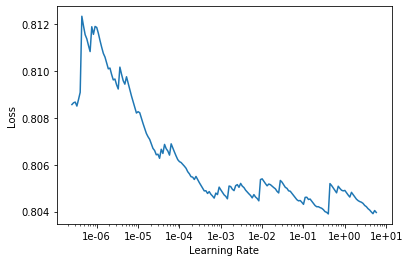

In [162]:
lr_find(learn, num_it=200)
learn.recorder.plot()

In [68]:
lr=3e-2

In [69]:
from fastai import callbacks

learn.fit_one_cycle(10, slice(lr), pct_start=0.3, 
                    callbacks=[callbacks.SaveModelCallback(learn, monitor='dice_coefficient',mode='max')])

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,time
0,0.177272,0.196987,0.968261,0.469160,0.858635,09:31
1,0.141360,0.196987,0.968261,0.469160,0.858635,09:28
2,0.154514,0.196987,0.968261,0.469160,0.858635,09:29


Better model found at epoch 0 with dice_coefficient value: 0.8586350679397583.


KeyboardInterrupt: 

In [42]:
learn.save('stage-1')

In [43]:
learn.load('bestmodel');

In [44]:
learn.export(file='/kaggle/model/export-1.pkl')

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DiceLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [45]:
learn.unfreeze()

In [46]:
lrs = slice(lr/100,lr)

In [47]:
learn.fit_one_cycle(5, lrs, pct_start=0.3, 
                    callbacks=[callbacks.SaveModelCallback(learn, monitor='dice_coefficient',mode='max')])

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,time
0,0.296443,0.323745,0.024142,0.373212,0.846048,10:26
1,0.411461,0.451755,0.006607,0.067648,1.004290,10:26
2,0.421311,0.451755,0.006607,0.067648,1.004290,10:28
3,0.988433,0.991349,0.006607,0.067648,1.004290,10:28
4,0.998870,0.996921,0.006607,0.067648,1.004290,10:23


Better model found at epoch 0 with dice_coefficient value: 0.8460484147071838.
Better model found at epoch 1 with dice_coefficient value: 1.0042897462844849.


In [ ]:
learn.save('stage-2');

In [ ]:
learn.load('bestmodel');

In [ ]:
learn.export(file='/kaggle/model/export-2.pkl')

### Go Large

In [ ]:
data = (src.transform(get_transforms(flip_vert = True), size=src_size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
learn.model_dir = Path('/kaggle/model')
learn.load('bestmodel');
learn.loss_func = DiceLoss()

In [ ]:
lr_find(learn, num_it=300)
learn.recorder.plot()

In [ ]:
lr=1e-06

In [ ]:
learn.fit_one_cycle(3, slice(lr), pct_start=0.3, 
                    callbacks=[callbacks.SaveModelCallback(learn, monitor='dice_coefficient',mode='max', name='bestmodel-3')])

In [ ]:
learn.save('stage-3');

In [ ]:
learn.export(file='/kaggle/model/export-3.pkl')

In [ ]:
learn.load('bestmodel-3');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/1000,lr/10)

In [ ]:
learn.fit_one_cycle(3, lrs, pct_start=0.8,
                   callbacks=[callbacks.SaveModelCallback(learn, monitor='acc_camvid_with_zero_check',mode='max', name='bestmodel-4')])

In [ ]:
learn.save('stage-4');

In [ ]:
learn.load('stage-4');

In [ ]:
learn.export(file='/kaggle/model/export-4.pkl')

In [ ]:
!pwd
!cp /kaggle/model/export.pkl /opt/fastai/fastai-exercises/nbs_gil
from IPython.display import FileLink
FileLink(r'export.pkl')

### Inference

In [ ]:
learn=None
gc.collect()

In [ ]:
test_images = (path/'test_images').ls()

In [ ]:
inference_learn = load_learner('/kaggle/model/')

In [ ]:
def predict(img_path):
    pred_class, pred_idx, outputs = inference_learn.predict(open_image(str(img_path)))
    return pred_class, pred_idx, outputs

def encode_classes(pred_class_data):
    pixels = np.concatenate([[0], torch.transpose(pred_class_data.squeeze(), 0, 1).flatten(), [0]])
    classes_dict = {1: [], 2: [], 3: [], 4: []}
    count = 0
    previous = pixels[0]
    for i, val in enumerate(pixels):
        if val != previous:
            if previous in classes_dict:
                classes_dict[previous].append((i - count, count))
            count = 0
        previous = val
        count += 1
    return classes_dict


def convert_classes_to_text(classes_dict, clazz):
    return ' '.join([f'{v[0]} {v[1]}' for v in classes_dict[clazz]])

In [ ]:
image_to_predict = train_images[16].name
display_image_with_mask(image_to_predict)
pred_class, pred_idx, outputs = predict(path/f'train_images/{image_to_predict}')
pred_class

#### Checking encoding methods

In [ ]:
encoded_all = encode_classes(pred_class.data)
print(convert_classes_to_text(encoded_all, 3))

In [ ]:
image_name = train_images[16]
print(get_y_fn(image_name))
img = open_mask(get_y_fn(image_name))
img_data = img.data
print(convert_classes_to_text(encode_classes(img_data), 3))
img_data.shape

### Loop through the test images and create submission csv

In [ ]:
import time
start_time = time.time()

defect_classes = [1, 2, 3, 4]
with open('submission.csv', 'w') as submission_file:
    submission_file.write('ImageId_ClassId,EncodedPixels\n')
    for i, test_image in enumerate(test_images):
        pred_class, pred_idx, outputs = predict(test_image)
        encoded_all = encode_classes(pred_class.data)
        for defect_class in defect_classes:
            submission_file.write(f'{test_image.name}_{defect_class},{convert_classes_to_text(encoded_all, defect_class)}\n')
        if i % 5 == 0:
            print(f'Processed {i} images\r', end='')
            
print(f"--- {time.time() - start_time} seconds ---")